# Project Loan Default Prediction

In [7]:
#All Libraries used
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#Split dataset 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#depois verificar se usámos tudo


In [8]:
#Import Dataset
#df = pd.read_csv('C:\ML\loan_default_prediction.csv')
df = pd.read_csv('loan_default_prediction.csv')
print(df.columns)
df=df.drop(['ID','GGGrade','Validation','Designation','Debt_to_Income','Postal_Code','Deprecatory_Records',\
            'Inquiries','Gross_Collection','Sub_GGGrade','Total_Unpaid_CL',],axis=1)
print(df.columns)

Index(['ID', 'Asst_Reg', 'GGGrade', 'Experience', 'Validation',
       'Yearly_Income', 'Home_Status', 'Unpaid_2_years', 'Already_Defaulted',
       'Designation', 'Debt_to_Income', 'Postal_Code', 'Lend_Amount',
       'Deprecatory_Records', 'Interest_Charged', 'Usage_Rate', 'Inquiries',
       'Present_Balance', 'Gross_Collection', 'Sub_GGGrade', 'File_Status',
       'State', 'Account_Open', 'Total_Unpaid_CL', 'Duration', 'Unpaid_Amount',
       'Reason', 'Claim_Type', 'Due_Fee', 'Default'],
      dtype='object')
Index(['Asst_Reg', 'Experience', 'Yearly_Income', 'Home_Status',
       'Unpaid_2_years', 'Already_Defaulted', 'Lend_Amount',
       'Interest_Charged', 'Usage_Rate', 'Present_Balance', 'File_Status',
       'State', 'Account_Open', 'Duration', 'Unpaid_Amount', 'Reason',
       'Claim_Type', 'Due_Fee', 'Default'],
      dtype='object')


In [9]:
#Conversão dos anos de experiencia para númerico
df['Experience']=df['Experience'].apply(lambda i: 10 if i[0:1]=='>' else 1 if i[0:1]=='<' else int(i[0:1]))
df.head()
#df['Experience'].describe()

,Asst_Reg,Experience,Yearly_Income,Home_Status,Unpaid_2_years,Already_Defaulted,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,File_Status,State,Account_Open,Duration,Unpaid_Amount,Reason,Claim_Type,Due_Fee,Default
0,421802,10,633600.00,MORTGAGE,0,0,42023.25,15.39,88.924,607161.90,fully paid,California,17,3 years,31216.05,debt consolidation,I,0.0,0
1,3964312,7,85483.20,RENT,0,0,38133.00,9.94,102.856,269234.06,whole,NC,15,5 years,11660.49,debt consolidation,I,0.0,0
2,4247560,1,79200.00,RENT,0,0,17100.00,22.35,60.372,22476.53,whole,Florida,7,5 years,5637.87,major purchase,I,0.0,0
3,197179,1,61600.00,RENT,0,0,5130.00,10.36,116.272,15242.09,fully paid,NewJersey,9,3 years,15607.17,major purchase,I,0.0,1
4,4646684,2,68053.92,RENT,0,0,19665.00,13.68,127.280,65433.94,fully paid,LA,10,5 years,27472.86,debt consolidation,I,0.0,0


In [10]:
#View Instances and Features
df.shape

(87500, 19)

In [11]:
#View info of dataset
display(df.isnull().sum())
df.info()

Asst_Reg                0
Experience              0
Yearly_Income        5575
Home_Status             0
Unpaid_2_years          0
Already_Defaulted       0
Lend_Amount             0
Interest_Charged        0
Usage_Rate              0
Present_Balance         0
File_Status             0
State                   0
Account_Open            0
Duration                0
Unpaid_Amount        4852
Reason                  0
Claim_Type              0
Due_Fee                 0
Default                 0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87500 entries, 0 to 87499
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Asst_Reg           87500 non-null  int64  
 1   Experience         87500 non-null  int64  
 2   Yearly_Income      81925 non-null  float64
 3   Home_Status        87500 non-null  object 
 4   Unpaid_2_years     87500 non-null  int64  
 5   Already_Defaulted  87500 non-null  int64  
 6   Lend_Amount        87500 non-null  float64
 7   Interest_Charged   87500 non-null  float64
 8   Usage_Rate         87500 non-null  float64
 9   Present_Balance    87500 non-null  float64
 10  File_Status        87500 non-null  object 
 11  State              87500 non-null  object 
 12  Account_Open       87500 non-null  int64  
 13  Duration           87500 non-null  object 
 14  Unpaid_Amount      82648 non-null  float64
 15  Reason             87500 non-null  object 
 16  Claim_Type         875

In [12]:
#drop empty
df=df.dropna()
df.isnull().sum()
df.shape

(77376, 19)

In [13]:
#depois ver onde fazer copy
num=df[df.columns[df.dtypes!='object']].drop(['Default'],axis=1)#só variáveis que são strings
num.head()

,Asst_Reg,Experience,Yearly_Income,Unpaid_2_years,Already_Defaulted,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,Account_Open,Unpaid_Amount,Due_Fee
0,421802,10,633600.00,0,0,42023.25,15.39,88.924,607161.90,17,31216.05,0.0
1,3964312,7,85483.20,0,0,38133.00,9.94,102.856,269234.06,15,11660.49,0.0
2,4247560,1,79200.00,0,0,17100.00,22.35,60.372,22476.53,7,5637.87,0.0
3,197179,1,61600.00,0,0,5130.00,10.36,116.272,15242.09,9,15607.17,0.0
4,4646684,2,68053.92,0,0,19665.00,13.68,127.280,65433.94,10,27472.86,0.0


In [14]:
#DATA FRAME COM VARIÁVEIS CONTINUAS
realnum=num[['Asst_Reg','Experience','Yearly_Income','Lend_Amount','Interest_Charged','Usage_Rate','Present_Balance',\
            'Unpaid_Amount']]

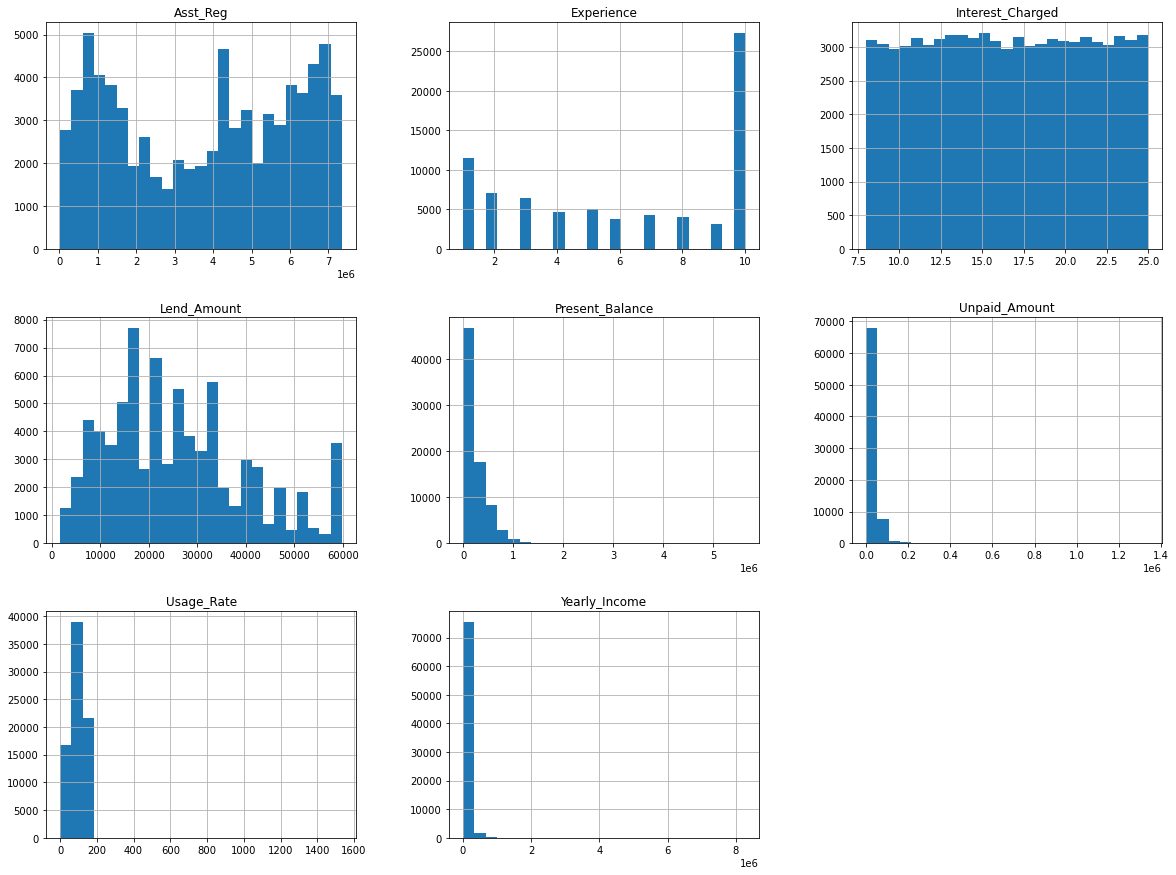

In [15]:
#plots
realnum.hist(bins=25,figsize=(20,15))
plt.show()

In [17]:
realnum.describe()

,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,Unpaid_Amount
count,7.737600e+04,77376.000000,7.737600e+04,77376.000000,77376.000000,77376.000000,7.737600e+04,7.737600e+04
mean,3.801793e+06,6.144360,1.349915e+05,25927.213109,16.518339,95.489869,2.363786e+05,2.953228e+04
std,2.289120e+06,3.538256,9.953162e+04,14443.738100,4.905345,40.610291,2.553444e+05,3.757589e+04
min,2.484700e+04,1.000000,8.800000e+03,1710.000000,8.000000,0.000000,0.000000e+00,0.000000e+00
25%,1.486830e+06,3.000000,8.330256e+04,15048.000000,12.310000,66.048000,5.181092e+04,1.144332e+04
50%,4.133126e+06,7.000000,1.144000e+05,23940.000000,16.490000,97.008000,1.386309e+05,2.088594e+04
75%,5.956216e+06,10.000000,1.601600e+05,34200.000000,20.772500,126.592000,3.535544e+05,3.643497e+04
max,7.351847e+06,10.000000,8.264031e+06,59850.000000,25.000000,1534.756000,5.629234e+06,1.338778e+06


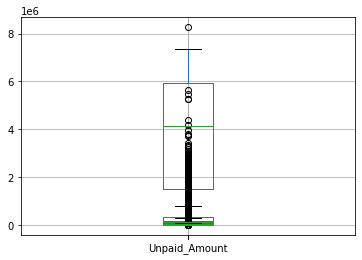

In [103]:
#df.boxplot(by ='day', column =['total_bill'], grid = False)
#realnum.boxplot(figsize=(20,15))
#plt.show()
#DataFrame.boxplot(column=None, by=None, ax=None, fontsize=None, rot=0, 
#grid=True, figsize=None, layout=None, return_type=None, backend=None, **kwargs)

for i in realnum.columns: df.boxplot(column = i)

In [5]:
#selecionar só objectos

cat=df[df.columns[df.dtypes!='object']] #só variáveis que são numeros, falta validar se há categóricas

In [20]:
#Get main statistics of numerical features
#df.value_counts()
#VER SE VARIAVEL NUMERICA TEM ALGUM STRING
df['Home_Status'].value_counts()

MORTGAGE    39077
RENT        30853
OWN          7436
OTHER           6
NONE            4
Name: Home_Status, dtype: int64

In [25]:
#df.columns
df.boxplot(columns = ['Home_Status'])

NameError: name 'box' is not defined

In [9]:
#drop duplicates
df.drop_duplicates().shape

(87500, 30)

In [11]:
#names features
df.columns
#rename para lower case?

Index(['ID', 'Asst_Reg', 'GGGrade', 'Experience', 'Validation',
       'Yearly_Income', 'Home_Status', 'Unpaid_2_years', 'Already_Defaulted',
       'Designation', 'Debt_to_Income', 'Postal_Code', 'Lend_Amount',
       'Deprecatory_Records', 'Interest_Charged', 'Usage_Rate', 'Inquiries',
       'Present_Balance', 'Gross_Collection', 'Sub_GGGrade', 'File_Status',
       'State', 'Account_Open', 'Total_Unpaid_CL', 'Duration', 'Unpaid_Amount',
       'Reason', 'Claim_Type', 'Due_Fee', 'Default'],
      dtype='object')

In [52]:
#ver nulos e na
print(df.isna().sum(axis=0))
df.isnull().sum(axis=0)/df.shape[0]*100 #converter para %, fazer round

ID                        0
Asst_Reg                  0
GGGrade                   0
Experience                0
Validation                0
Yearly_Income          5575
Home_Status               0
Unpaid_2_years            0
Already_Defaulted         0
Designation            1414
Debt_to_Income         3489
Postal_Code            1389
Lend_Amount               0
Deprecatory_Records       0
Interest_Charged          0
Usage_Rate                0
Inquiries                 0
Present_Balance           0
Gross_Collection          0
Sub_GGGrade               0
File_Status               0
State                     0
Account_Open              0
Total_Unpaid_CL        4186
Duration                  0
Unpaid_Amount          4852
Reason                    0
Claim_Type                0
Due_Fee                   0
Default                   0
dtype: int64


ID                     0.000000
Asst_Reg               0.000000
GGGrade                0.000000
Experience             0.000000
Validation             0.000000
Yearly_Income          6.371429
Home_Status            0.000000
Unpaid_2_years         0.000000
Already_Defaulted      0.000000
Designation            1.616000
Debt_to_Income         3.987429
Postal_Code            1.587429
Lend_Amount            0.000000
Deprecatory_Records    0.000000
Interest_Charged       0.000000
Usage_Rate             0.000000
Inquiries              0.000000
Present_Balance        0.000000
Gross_Collection       0.000000
Sub_GGGrade            0.000000
File_Status            0.000000
State                  0.000000
Account_Open           0.000000
Total_Unpaid_CL        4.784000
Duration               0.000000
Unpaid_Amount          5.545143
Reason                 0.000000
Claim_Type             0.000000
Due_Fee                0.000000
Default                0.000000
dtype: float64

In [18]:
#se quisermos simplesmente apagar os missing values
#df.drop.na().copy()
#se se quiser apagar a variavel com brancos
#df.drop.na(axis=1).copy()
#para fazer fill dos brancos7na, fazemos pipeline

In [19]:
#ver estatísticas descritivas
df.describe() #ver se fazemos só para as numerica
#VER OUTLIERS
#precisamos de distinguir entre numerical e categorical
#ver se queremos incluir medidas de assimetria e curtose

,ID,Asst_Reg,Yearly_Income,Unpaid_2_years,Already_Defaulted,Debt_to_Income,Postal_Code,Lend_Amount,Deprecatory_Records,Interest_Charged,Usage_Rate,Inquiries,Present_Balance,Gross_Collection,Sub_GGGrade,Account_Open,Total_Unpaid_CL,Unpaid_Amount,Due_Fee,Default
count,87500.000000,8.750000e+04,8.192500e+04,87500.000000,87500.000000,84011.000000,86111.000000,87500.000000,87500.000000,87500.000000,87500.000000,87500.000000,8.750000e+04,87500.000000,87500.000000,87500.00000,8.331400e+04,8.264800e+04,87500.000000,87500.000000
mean,83946.253509,3.798914e+06,1.348596e+05,0.332937,0.005726,30.942660,51155.385491,25920.535680,0.202400,16.518375,95.517348,0.670640,2.363895e+05,39.461697,22.024891,12.77944,5.326864e+04,2.955649e+04,0.316407,0.188709
std,36100.102950,2.289038e+06,9.882473e+04,0.876080,0.083505,14.079813,31211.229930,14433.837213,0.646414,4.902011,40.554035,0.959572,2.550568e+05,391.919578,6.452697,5.37116,5.325551e+04,3.745625e+04,3.546087,0.391279
min,21560.000000,2.484700e+04,8.800000e+03,0.000000,0.000000,0.000000,1000.000000,1710.000000,0.000000,8.000000,0.000000,0.000000,0.000000e+00,0.000000,11.000000,2.00000,3.320000e+02,0.000000e+00,0.000000,0.000000
25%,52616.750000,1.483874e+06,8.324659e+04,0.000000,0.000000,20.428800,22900.000000,15048.000000,0.000000,12.310000,66.048000,0.000000,5.173493e+04,0.000000,17.000000,9.00000,2.324000e+04,1.144674e+04,0.000000,0.000000
50%,83900.000000,4.132010e+06,1.144000e+05,0.000000,0.000000,30.139200,47700.000000,23940.000000,0.000000,16.490000,97.008000,0.000000,1.388062e+05,0.000000,21.000000,12.00000,3.967400e+04,2.089278e+04,0.000000,0.000000
75%,115261.250000,5.952909e+06,1.601600e+05,0.000000,0.000000,40.908000,80200.000000,34200.000000,0.000000,20.770000,126.592000,1.000000,3.534755e+05,0.000000,26.000000,16.00000,6.640000e+04,3.644908e+04,0.000000,0.000000
max,146559.000000,7.351847e+06,8.264031e+06,18.000000,6.000000,639.290400,99900.000000,59850.000000,86.000000,25.000000,1534.756000,8.000000,5.629234e+06,26308.470000,45.000000,83.00000,1.710630e+06,1.338778e+06,169.050000,1.000000


In [53]:
#fazer value_counts() das variáveis que são ordinais e categóricas
df['Default'].value_counts()/df.shape[0] #quantos defaults temos
#print(df[df['Default']==1]['Default'].value_counts())

0    0.811291
1    0.188709
Name: Default, dtype: float64

In [22]:
#ver correlações
df.corr()
#cuidado com a corr nas categoricas!

,ID,Asst_Reg,Yearly_Income,Unpaid_2_years,Already_Defaulted,Debt_to_Income,Postal_Code,Lend_Amount,Deprecatory_Records,Interest_Charged,Usage_Rate,Inquiries,Present_Balance,Gross_Collection,Sub_GGGrade,Account_Open,Total_Unpaid_CL,Unpaid_Amount,Due_Fee,Default
ID,1.000000,-0.004932,-0.004590,0.000555,0.004238,0.001532,-0.002164,0.001572,-0.002400,0.000627,-0.000986,-0.002318,0.005622,0.000753,-0.005514,0.002724,0.002056,0.001478,-0.002503,0.000671
Asst_Reg,-0.004932,1.000000,0.035298,0.034842,0.011144,0.088523,-0.014156,0.035463,0.060083,-0.003918,-0.074356,-0.109052,0.010265,-0.111597,-0.027765,0.055217,0.059253,0.031855,-0.064833,-0.413534
Yearly_Income,-0.004590,0.035298,1.000000,0.048105,0.015212,-0.217565,-0.003886,0.379753,-0.006023,0.000878,0.046539,0.042901,0.480756,0.011979,-0.087292,0.147274,0.342919,0.346428,0.010316,-0.002872
Unpaid_2_years,0.000555,0.034842,0.048105,1.000000,0.139225,-0.017023,-0.030558,-0.012538,-0.013911,0.000769,-0.018248,0.032898,0.064146,0.000142,0.058871,0.044931,-0.048703,-0.034495,0.020816,-0.030021
Already_Defaulted,0.004238,0.011144,0.015212,0.139225,1.000000,0.000945,-0.008595,0.000148,0.000338,-0.002908,-0.031001,-0.003279,0.020608,-0.000966,0.029875,0.015250,0.009123,0.001204,0.011485,-0.008235
Debt_to_Income,0.001532,0.088523,-0.217565,-0.017023,0.000945,1.000000,0.004370,0.032461,-0.051685,-0.002211,0.162391,-0.004063,-0.009076,0.008508,0.175669,0.292328,0.084394,0.138476,-0.000393,-0.090758
Postal_Code,-0.002164,-0.014156,-0.003886,-0.030558,-0.008595,0.004370,1.000000,-0.005100,-0.008839,0.001059,0.013406,0.007374,-0.008646,0.009521,-0.006331,-0.050865,-0.034395,-0.025425,-0.005567,0.032574
Lend_Amount,0.001572,0.035463,0.379753,-0.012538,0.000148,0.032461,-0.005100,1.000000,-0.080907,-0.002999,0.115829,-0.030195,0.323443,0.070179,0.144200,0.180107,0.356740,0.343999,0.036821,-0.059486
Deprecatory_Records,-0.002400,0.060083,-0.006023,-0.013911,0.000338,-0.051685,-0.008839,-0.080907,1.000000,0.002984,-0.080653,0.072078,-0.065633,-0.010535,0.051904,-0.024598,-0.116259,-0.095573,-0.005655,-0.021013
Interest_Charged,0.000627,-0.003918,0.000878,0.000769,-0.002908,-0.002211,0.001059,-0.002999,0.002984,1.000000,-0.000879,-0.001635,-0.003021,-0.003095,-0.005658,0.001527,0.005934,0.003211,-0.001339,0.005988


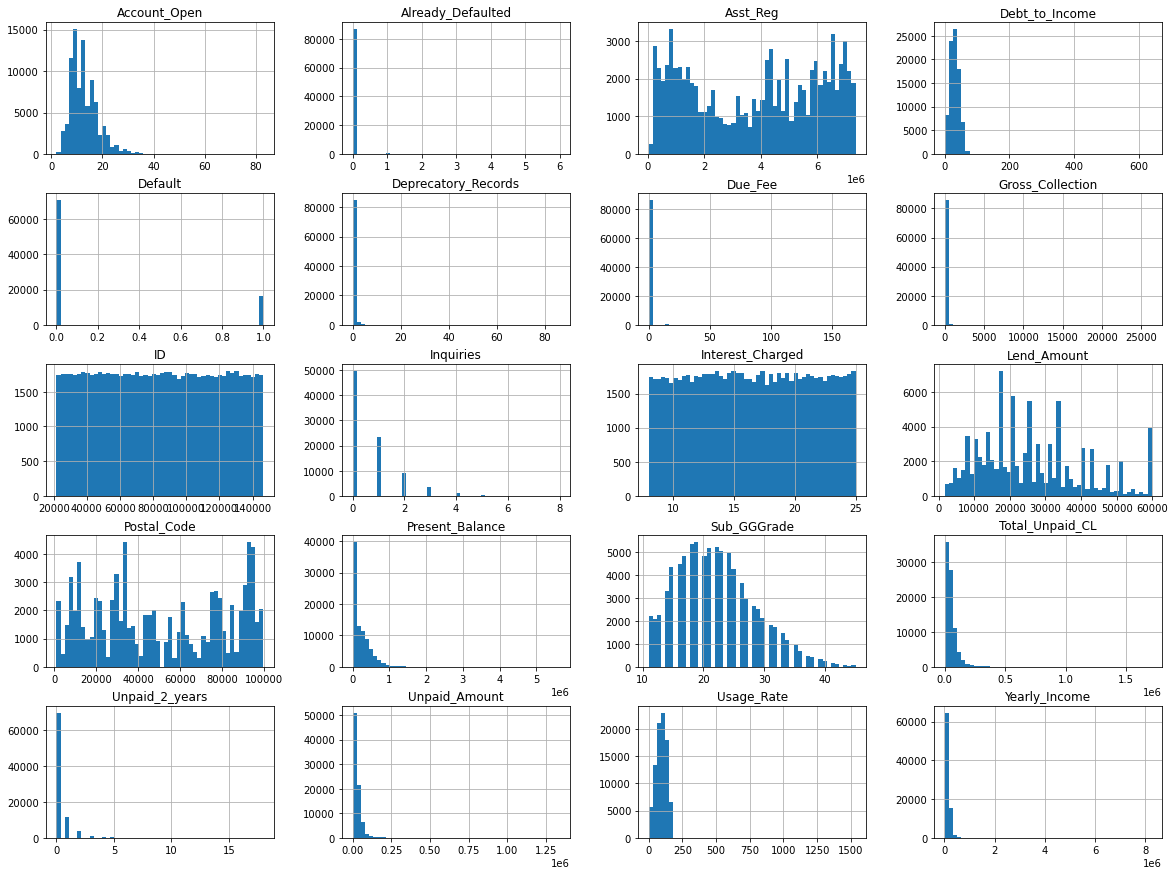

In [44]:
#plots
df.hist(bins=50,figsize=(20,15))
plt.show()
#boxplot???

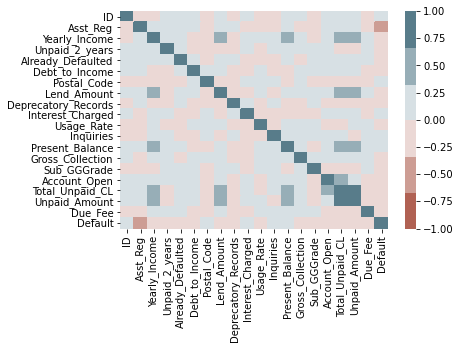

In [45]:
c=df.corr()
sns.heatmap(c,vmin=-1,vmax=1,center=0,cmap=sns.diverging_palette(20,220,50))

In [46]:
#train_set, test_set =train_test_split(df,test_size=0.2,random_state=1)
#ver como fazer para manter a % de defaults entre train e test!

In [11]:
#pipeline
class NewAttributes(BaseEstimator,TransformerMixin):
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        test=X[:,2]/X[:,3]

In [7]:
#Análise das features
df['Experience'].value_counts()

10    30849
1     13062
2      8064
3      7350
5      5623
4      5324
7      4762
8      4604
6      4255
9      3607
Name: Experience, dtype: int64

Text(0.5, 1.0, 'Valor dos bens')

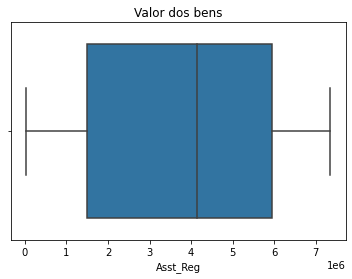

In [14]:

sns.boxplot(x=df["Asst_Reg"])
plt.title("Valor dos bens")

In [ ]:
#Detecção de outlier usando Box Plot#
sns.catplot(x='ID',  
            y='Asst_Reg', 
            data=df, 
            kind='box'); 
